In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import math
import aesara.tensor as at
import seaborn as sb
import matplotlib
import pickle

In [2]:
train_data = pd.read_csv(
    "../data_acquisition/data_0.3/training_standardized.csv", sep=";"
)

In [3]:
features = np.swapaxes(
    np.array(
        [
            train_data["home_xG"],
            train_data["away_xg_against"],
            train_data["away_xG"],
            train_data["home_xg_against"],
            train_data["home_xT_all"],
            train_data["away_xt_all_against"],
            train_data["away_xT_all"],
            train_data["home_xt_all_against"],
        ]
    ),
    0,
    1,
)

# gi = np.swapaxes(np.array([train_data["home_gi"], train_data["away_gi"]]), 0, 1)

form = np.swapaxes(
    np.array(
        [
            (train_data["ha_form_home_for"]),
            (train_data["ha_form_home_against"]),
            (train_data["ha_form_away_for"]),
            (train_data["ha_form_away_against"]),
        ]
    ),
    0,
    1,
)

goals = np.swapaxes(
    np.array([train_data["home_score"], train_data["away_score"]]), 0, 1
)

elo_diff = np.swapaxes(
    np.array([(train_data["elo_diff_home"]), (train_data["elo_diff_away"])]), 0, 1
)




In [4]:
with pm.Model() as independent_poisson:
    pm_features = pm.Data("pm_features", features, mutable=True)
    pm_form_diff = pm.Data("pm_form_diff", form, mutable=True)
    pm_goals = pm.Data("pm_goals", goals, mutable=True)
    pm_elo_diff = pm.Data("pm_elo_diff", elo_diff, mutable=True)

    coefs_features = pm.Normal(
    # coefs_features = pm.HalfNormal(
        "coefs_features",  # mu=[[1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1]],
        # sigma=[
        #     [1, 0.001],
        #     [1, 0.001],
        #     [0.001, 1],
        #     [0.001, 1],
        #     [1, 0.001],
        #     [1, 0.001],
        #     [0.001, 1],
        #     [0.001, 1],
        # ],
        shape=(features.shape[1], 2),
    )

    coefs_elo_diff = pm.Normal(
        "coefs_elo_diff",
        # mu=[0.5, -0.5], sigma=[0.2, 0.2], 
        shape=(elo_diff.shape[1], 2)
    )

    coefs_form_diff = pm.Normal(
        "coefs_form_diff", shape=(form.shape[1], 2)
    )  # ,mu=[0.5, -0.5]
    # factor = pm.Dirichlet("factor", a=np.ones(3))
    # home_advantage = pm.HalfNormal("home_advantage",sigma=[1, 0.001], shape=(2))
    intercepts = pm.Normal("intercepts", shape=2)

    # log_lam = pm.Deterministic("log_lam", intercepts + home_advantage +
    #                                                     factor[0]*(pm_elo_diff @ coefs_elo_diff) +
    #                                                     factor[1]*(pm_form_diff @ coefs_form_diff) +
    #                                                     factor[2]*(pm_features @ coefs_features))

    # log_lam = pm.Deterministic("log_lam", intercepts + home_advantage +
    #                                                 0.1*(pm_elo_diff @ coefs_elo_diff) +
    #                                                 0.4*(pm_form_diff @ coefs_form_diff) +
    #                                                 0.5*(pm_features @ coefs_features))

    # log_lam = pm.Deterministic(
    #     "log_lam",
    #     intercepts
    #     + 0.1 * (pm_elo_diff @ coefs_elo_diff)
    #     + 0.4 * (pm_form_diff @ coefs_form_diff)
    #     + 0.5 * (pm_features @ coefs_features),
    # )
    log_lam = pm.Deterministic(
        "log_lam",
        intercepts
        + (pm_elo_diff @ coefs_elo_diff)
        + (pm_form_diff @ coefs_form_diff)
        + (pm_features @ coefs_features),
    )


    lam = pm.math.exp(log_lam)

    obs = pm.Poisson("obs", mu=lam, observed=pm_goals)

In [5]:
# N = train_data.shape[0]
# K = 2
# features = np.swapaxes(
#     np.array(
#         [
#             train_data["home_xG"] - xg_mean,
#             train_data["away_xg_against"] - xg_against_mean,
#             train_data["away_xG"] - xg_mean,
#             train_data["home_xg_against"] - xg_against_mean,
#             train_data["home_xT_all"] - xt_mean,
#             train_data["away_xt_all_against"] - xt_against_mean,
#             train_data["away_xT_all"] - xt_mean,
#             train_data["home_xt_all_against"] - xt_against_mean,
#         ]
#     ),
#     0,
#     1,
# )

# # gi = np.swapaxes(np.array([train_data["home_gi"], train_data["away_gi"]]), 0, 1)

# form = np.swapaxes(
#     np.array(
#         [
#             (train_data["ha_form_home_for"] / 5) - form_for_mean,
#             (train_data["ha_form_home_against"] / 5) - form_against_mean,
#             (train_data["ha_form_away_for"] / 5) - form_for_mean,
#             (train_data["ha_form_away_against"] / 5) - form_against_mean,
#         ]
#     ),
#     0,
#     1,
# )

# goals = np.swapaxes(
#     np.array([train_data["home_score"], train_data["away_score"]]), 0, 1
# )

# elo_diff = np.swapaxes(
#     np.array([(train_data["elo_home"] / 1000) - (train_data["elo_away"] / 1000)]), 0, 1
# )
# # elo_a = np.swapaxes(np.array(), 0, 1)
# M = 10

# with pm.Model() as dependent_normal_1:
#     pm_features = pm.Data("pm_features", features, mutable=True)
#     pm_form_diff = pm.Data("pm_form_diff", form, mutable=True)
#     pm_goals = pm.Data("pm_goals", goals, mutable=True)
#     pm_elo_diff = pm.Data("pm_elo_diff", elo_diff, mutable=True)

#     cov_diag = pm.HalfNormal("cov_diag", shape=K)
#     cov_root = pm.Normal("cov_root", shape=(M, K))
#     cov = pm.Deterministic("cov", cov_root.T @ cov_root + at.diag(cov_diag))

#     coefs_features = pm.HalfNormal(
#         "coefs_features",  # mu=[[1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1]],
#         sigma=[
#             [1, 0.001],
#             [1, 0.001],
#             [0.001, 1],
#             [0.001, 1],
#             [1, 0.001],
#             [1, 0.001],
#             [0.001, 1],
#             [0.001, 1],
#         ],
#         shape=(features.shape[1], 2),
#     )

#     coefs_elo_diff = pm.Normal(
#         "coefs_elo_diff", mu=[0.5, -0.5], sigma=[0.2, 0.2], shape=(1, 2)
#     )

#     coefs_form_diff = pm.Normal(
#         "coefs_form_diff", shape=(form.shape[1], 2)
#     )  # ,mu=[0.5, -0.5]
#     factor = pm.Dirichlet("factor", a=np.ones(3))
#     # home_advantage = pm.HalfNormal("home_advantage",sigma=[1, 0.001], shape=(2))
#     intercepts = pm.Normal("intercepts", shape=2)

#     log_lam = pm.MvNormal(
#         "log_lam",
#         intercepts
#         + 0.1 * (pm_elo_diff @ coefs_elo_diff)
#         + 0.4 * (pm_form_diff @ coefs_form_diff)
#         + 0.5 * (pm_features @ coefs_features),
#         cov=cov,
#         shape=(K),
#     )

#     lam = pm.math.exp(log_lam)

#     obs = pm.Poisson("obs", mu=lam, observed=pm_goals)

In [6]:
# features = np.swapaxes(np.array([train_data["home_xG"] - xg_mean, train_data["away_xg_against"] - xg_against_mean,
#                                 train_data["away_xG"] - xg_mean, train_data["home_xg_against"] - xg_against_mean]), 0, 1)
# # features_a = np.swapaxes(np.array([train_data["away_xG"], train_data["away_xT_only_pos"], train_data["home_xg_against"], train_data["home_xt_only_pos_against"]]), 0, 1)

# gi = np.swapaxes(np.array([train_data["home_gi"], train_data["away_gi"]]), 0, 1)
# # gi_a = np.swapaxes(np.array([train_data["away_gi"]]), 0, 1)

# form = np.swapaxes(np.array([(train_data["form_home_for"] / 5) - form_for_mean, (train_data["form_home_against"] / 5) - form_against_mean,
#                             (train_data["form_away_for"] / 5) - form_for_mean, (train_data["form_away_against"] / 5) - form_against_mean]), 0, 1)

# goals = np.swapaxes(np.array([train_data["home_score"], train_data["away_score"]]), 0, 1)
# # goals_a = np.swapaxes(np.array([train_data["away_score"]]), 0, 1)

# elo_diff = np.swapaxes(np.array([(train_data["elo_home"] / 1000) - (train_data["elo_away"] / 1000)]), 0, 1)

# with pm.Model() as dependent_normal_2:
#     pm_features = pm.Data("pm_features", features, mutable=True)
#     pm_form_diff = pm.Data("pm_form_diff", form, mutable=True)

#     sd_dist = pm.HalfNormal.dist(shape=2)
#     chol, corr, stds = pm.LKJCholeskyCov('chol_cov', n=2, eta=2, sd_dist=sd_dist, compute_corr=True)

#     coefs = pm.Normal('coefs', shape=(features.shape[1], 2))
#     coefs_form = pm.Normal('coefs_form', shape=(form.shape[1], 2))

#     intercepts = pm.Normal('intercepts', shape=2)
#     log_lam = pm.MvNormal('log_lam', mu=intercepts + (pm_features @ coefs) +
#                                                      (pm_form_diff @ coefs_form), chol=chol, shape=(2))
#     lam = pm.math.exp(log_lam)
#     obs = pm.Poisson('obs', mu=lam, observed=goals)

In [7]:
MODEL = independent_poisson
# MODEL = dependent_normal_1
# MODEL = dependent_normal_2

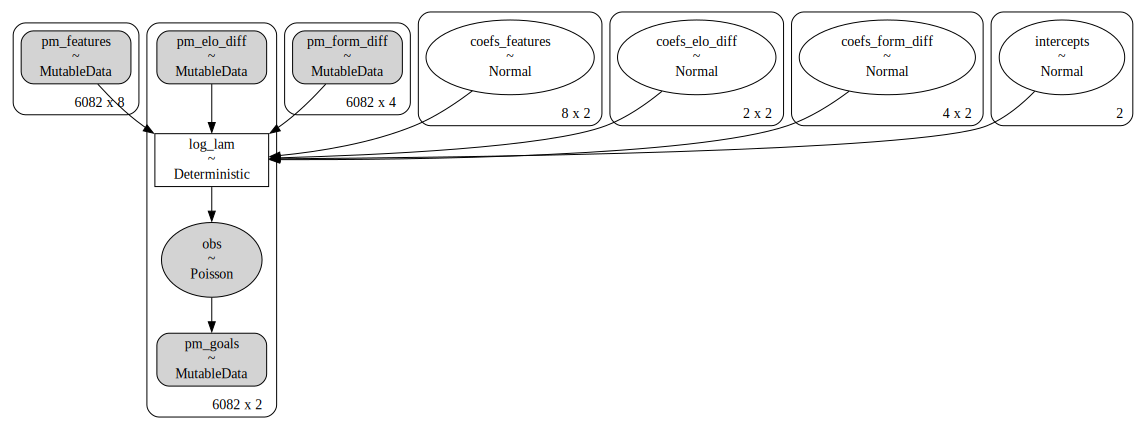

In [8]:
pm.model_to_graphviz(MODEL)

In [9]:
with MODEL:
    # trace = pm.sample(1000, tune=1000, return_inferencedata=True, discard_tuned_samples=True)
    app = pm.fit(50000, progressbar=True)
    trace = app.sample(1000)

Finished [100%]: Average Loss = 16,391


In [43]:
# trace.to_netcdf("models/independent_trace.nc")
# trace = az.from_netcdf("../models/independent_trace.nc").load()

'models/independent_trace.nc'

# Test

In [10]:
test_data = pd.read_csv(
    "../data_acquisition/data_0.3/test_standardized.csv", sep=";"
).dropna()


test_data_orig_size = test_data.shape[0]
size_diff = train_data.shape[0] - test_data.shape[0]
column_size = test_data.shape[1]
fill_data = [np.ones(column_size) for _ in range(size_diff)]
test_data_fill = pd.DataFrame(data=fill_data, columns=test_data.columns)
test_data = pd.concat([test_data, test_data_fill])

features = np.swapaxes(
    np.array(
        [
            test_data["home_xG"],
            test_data["away_xg_against"],
            test_data["away_xG"],
            test_data["home_xg_against"],
            test_data["home_xT_all"],
            test_data["away_xT_all"],
            test_data["home_xt_all_against"],
            test_data["away_xt_all_against"],
        ]
    ),
    0,
    1,
)
# features_a = np.swapaxes(np.array([train_data["away_xG"], train_data["away_xT_only_pos"], train_data["home_xg_against"], train_data["home_xt_only_pos_against"]]), 0, 1)

# gi = np.swapaxes(np.array([test_data["home_gi"], test_data["away_gi"]]), 0, 1)
# gi_a = np.swapaxes(np.array([train_data["away_gi"]]), 0, 1)

form = np.swapaxes(
    np.array(
        [
            (test_data["ha_form_home_for"]),
            (test_data["ha_form_home_against"]),
            (test_data["ha_form_away_for"]),
            (test_data["ha_form_away_against"]),
        ]
    ),
    0,
    1,
)

goals = np.swapaxes(np.array([test_data["home_score"], test_data["away_score"]]), 0, 1)

elo = np.swapaxes(
    np.array([(test_data["elo_diff_home"]), (test_data["elo_diff_away"])]), 0, 1
)

with MODEL:
    pm.set_data(
        {
            "pm_elo_diff": elo,
            "pm_features": features,
            "pm_form_diff": form,
        }
    )

    sample_res = pm.sample_posterior_predictive(trace, predictions=True)
    predictions = sample_res["predictions"]

In [11]:
actual_home = test_data[:test_data_orig_size].home_score
actual_away = test_data[:test_data_orig_size].away_score
act_res = []
for h, a in zip(actual_home, actual_away):
    act_res.append(f"{str(int(h))}:{str(int(a))}")

predictions_home = np.swapaxes(np.array(predictions.obs[0].values), 0, 1)[
    :test_data_orig_size
][:, :, 0]
predictions_away = np.swapaxes(np.array(predictions.obs[0].values), 0, 1)[
    :test_data_orig_size
][:, :, 1]
game_quotes = []
most_goals = {"home": [], "away": []}
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6]
    )
    away_hist, bin_edges = np.histogram(
        predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6]
    )
    home, draw, away = 0, 0, 0
    for i in range(len(home_hist)):
        for j in range(len(away_hist)):
            if j < i:
                home += (home_hist[i] / 1000) * (away_hist[j] / 1000)
            elif j == i:
                draw += (home_hist[i] / 1000) * (away_hist[j] / 1000)
            elif j > i:
                away += (home_hist[i] / 1000) * (away_hist[j] / 1000)

    game_quotes.append(f"{round(home, 3)}-{round(draw, 3)}-{round(away, 3)}")
    most_goals["home"].append(
        f"h: {np.argmax(home_hist)} - {round(np.max(home_hist)/10)}%"
    )
    most_goals["away"].append(
        f"a: {np.argmax(away_hist)} - {round(np.max(away_hist)/10)}%"
    )

df_res = pd.DataFrame(
    {
        "actual": act_res,
        "predicted": game_quotes,
        "prob goals home": most_goals["home"],
        "prob goals away": most_goals["away"],
    }
)
df_cross = pd.DataFrame(
    {
        "actual": [
            0
            if int(df_res.iloc[i]["actual"].split(":")[0])
            > int(df_res.iloc[i]["actual"].split(":")[1])
            else 1
            if int(df_res.iloc[i]["actual"].split(":")[0])
            == int(df_res.iloc[i]["actual"].split(":")[1])
            else 2
            for i in range(df_res.shape[0])
        ],
        "pred": [
            np.argmax([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
            for i in range(df_res.shape[0])
        ],
        "pred_val": [
            np.max([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
            for i in range(df_res.shape[0])
        ],
        "bookie": [
            np.argmax(
                [
                    test_data.iloc[i].bookie_home,
                    test_data.iloc[i].bookie_draw,
                    test_data.iloc[i].bookie_away,
                ]
            )
            for i in range(test_data_orig_size)
        ],
        "bookie_val": [
            np.max(
                [
                    test_data.iloc[i].bookie_home,
                    test_data.iloc[i].bookie_draw,
                    test_data.iloc[i].bookie_away,
                ]
            )
            for i in range(test_data_orig_size)
        ],
    }
)

In [12]:
df_res.head(25)

,actual,predicted,prob goals home,prob goals away
0,1:1,0.606-0.243-0.15,h: 1 - 30%,a: 0 - 53%
1,1:0,0.414-0.305-0.281,h: 1 - 37%,a: 0 - 41%
2,2:0,0.693-0.186-0.118,h: 2 - 27%,a: 0 - 46%
3,2:1,0.756-0.146-0.079,h: 3 - 26%,a: 0 - 49%
4,0:1,0.367-0.281-0.351,h: 1 - 35%,a: 1 - 36%
5,2:1,0.563-0.18-0.239,h: 2 - 25%,a: 1 - 27%
6,1:1,0.106-0.153-0.724,h: 0 - 41%,a: 2 - 26%
7,2:2,0.607-0.191-0.191,h: 2 - 28%,a: 1 - 35%
8,1:2,0.09-0.148-0.733,h: 0 - 44%,a: 2 - 24%
9,2:1,0.085-0.098-0.695,h: 1 - 34%,a: 5 - 26%


In [13]:
print("Verteilung:")
print(
    f"Anzahl Predicted Home: {df_cross[df_cross['pred'] == 0].shape[0]} ({round(df_cross[df_cross['pred'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Home: {round(df_cross[df_cross['actual'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    f"Anzahl Predicted Draw: {df_cross[df_cross['pred'] == 1].shape[0]} ({round(df_cross[df_cross['pred'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Draw: {round(df_cross[df_cross['actual'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    f"Anzahl Predicted Away: {df_cross[df_cross['pred'] == 2].shape[0]} ({round(df_cross[df_cross['pred'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Away: {round(df_cross[df_cross['actual'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    "---------------------------------------------------------------------------------"
)
right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
home_pred = {"act_away": 0, "act_draw": 0}
draw_pred = {"act_away": 0, "act_home": 0}
away_pred = {"act_home": 0, "act_draw": 0}
for x in range(df_cross.shape[0]):
    if df_cross.iloc[x]["actual"] != df_cross.iloc[x]["pred"]:
        if df_cross.iloc[x]["pred"] == 0:
            if df_cross.iloc[x]["actual"] == 1:
                home_pred["act_draw"] += 1
            else:
                home_pred["act_away"] += 1
        elif df_cross.iloc[x]["pred"] == 1:
            if df_cross.iloc[x]["actual"] == 0:
                draw_pred["act_home"] += 1
            else:
                draw_pred["act_away"] += 1
        else:
            if df_cross.iloc[x]["actual"] == 0:
                away_pred["act_home"] += 1
            else:
                away_pred["act_draw"] += 1
        wrong += 1
    else:
        if df_cross.iloc[x]["actual"] == 0:
            home_right += 1
        elif df_cross.iloc[x]["actual"] == 1:
            draw_right += 1
        else:
            away_right += 1
        right += 1

home_wrong = home_pred["act_away"] + home_pred["act_draw"]
draw_wrong = draw_pred["act_away"] + draw_pred["act_home"]
away_wrong = away_pred["act_home"] + away_pred["act_draw"]
print("Prediction:")
print(
    f"Anzahl Korrekt: {right} ({round(right / df_cross.shape[0] * 100,2)}%), Anzahl Falsch: {wrong} ({round(wrong / df_cross.shape[0] * 100, 2)}%)"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    f"Anzahl Home Korrekt: {home_right} ({round(home_right / df_cross[df_cross['actual'] == 0].shape[0] * 100, 2)}%), Anzahl Home Falsch: {home_wrong}"
)
print(f"Home Pred. aber Draw --> {home_pred['act_draw']}")
print(f"Home Pred. aber Away --> {home_pred['act_away']}")
print(
    f"Anzahl Draw Korrekt: {draw_right} ({round(draw_right / df_cross[df_cross['actual'] == 1].shape[0] * 100, 2)}%), Anzahl Draw Falsch: {draw_wrong}"
)
print(f"Draw Pred. aber Home --> {draw_pred['act_home']}")
print(f"Draw Pred. aber Away --> {draw_pred['act_away']}")
print(
    f"Anzahl Away Korrekt: {away_right} ({round(away_right / df_cross[df_cross['actual'] == 2].shape[0] * 100, 2)}%), Anzahl Away Falsch: {away_wrong}"
)
print(f"Away Pred. aber Home --> {away_pred['act_home']}")
print(f"Away Pred. aber Draw --> {away_pred['act_draw']}")

Verteilung:
Anzahl Predicted Home: 935 (60.52%) | Verteilung Tatsächlich Home: 42.78%
Anzahl Predicted Draw: 42 (2.72%) | Verteilung Tatsächlich Draw: 25.5%
Anzahl Predicted Away: 568 (36.76%) | Verteilung Tatsächlich Away: 31.72%
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Prediction:
Anzahl Korrekt: 886 (57.35%), Anzahl Falsch: 659 (42.65%)
---------------------------------------------------------------------------------
Anzahl Home Korrekt: 551 (83.36%), Anzahl Home Falsch: 384
Home Pred. aber Draw --> 219
Home Pred. aber Away --> 165
Anzahl Draw Korrekt: 20 (5.08%), Anzahl Draw Falsch: 22
Draw Pred. aber Home --> 12
Draw Pred. aber Away --> 10
Anzahl Away Korrekt: 315 (64.29%), Anzahl Away Falsch: 253
Away Pred. aber Home --> 98
Away Pred. aber Draw --> 155


In [14]:
home_histograms, away_histograms = [], []
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6]
    )
    away_hist, bin_edges = np.histogram(
        predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6]
    )
    home_histograms.append(home_hist)
    away_histograms.append(away_hist)

home_cum_hist = np.sum(home_histograms, axis=0)
away_cum_hist = np.sum(away_histograms, axis=0)

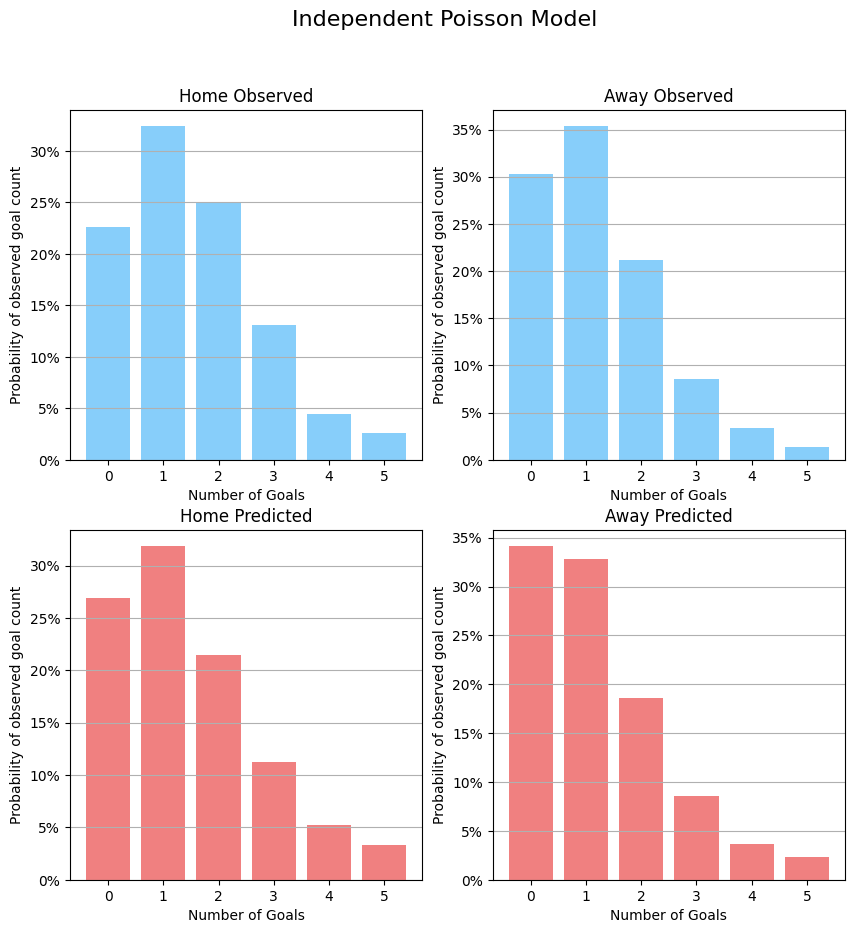

In [15]:
his_h, _ = np.histogram(train_data.home_score, [0, 1, 2, 3, 4, 5, 6])
his_a, _ = np.histogram(train_data.away_score, [0, 1, 2, 3, 4, 5, 6])
fig, (ax1, ax2) = plt.subplots(2, 2)
fig.set_size_inches(10, 10)
fig.suptitle("Independent Poisson Model", fontsize=16)
ax1[0].bar(np.arange(len(his_h)), his_h / np.sum(his_h), color="lightskyblue")
ax1[0].set_title("Home Observed")
ax1[0].set_xlabel("Number of Goals")
ax1[0].set_ylabel("Probability of observed goal count")
ax1[0].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax1[0].grid(axis="y")

ax2[0].bar(
    np.arange(len(home_cum_hist)),
    home_cum_hist / np.sum(home_cum_hist),
    color="lightcoral",
)
ax2[0].set_title("Home Predicted")
ax2[0].set_xlabel("Number of Goals")
ax2[0].set_ylabel("Probability of observed goal count")
ax2[0].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax2[0].grid(axis="y")

ax1[1].bar(np.arange(len(his_a)), his_a / np.sum(his_a), color="lightskyblue")
ax1[1].set_title("Away Observed")
ax1[1].set_xlabel("Number of Goals")
ax1[1].set_ylabel("Probability of observed goal count")
ax1[1].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax1[1].grid(axis="y")

ax2[1].bar(
    np.arange(len(away_cum_hist)),
    away_cum_hist / np.sum(away_cum_hist),
    color="lightcoral",
)
ax2[1].set_title("Away Predicted")
ax2[1].set_xlabel("Number of Goals")
ax2[1].set_ylabel("Probability of observed goal count")
ax2[1].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax2[1].grid(axis="y")

In [16]:
print("observed")
print(np.mean(train_data.home_score))
print(np.mean(train_data.away_score))

observed
1.5348569549490299
1.2387372574810918


In [17]:
print(np.sum([x * idx for idx, x in enumerate(home_cum_hist)]) / np.sum(home_cum_hist))
print(np.sum([x * idx for idx, x in enumerate(away_cum_hist)]) / np.sum(away_cum_hist))

1.4582881595669062
1.2171925484932145


Text(0.5, 1.0, 'Predicted')

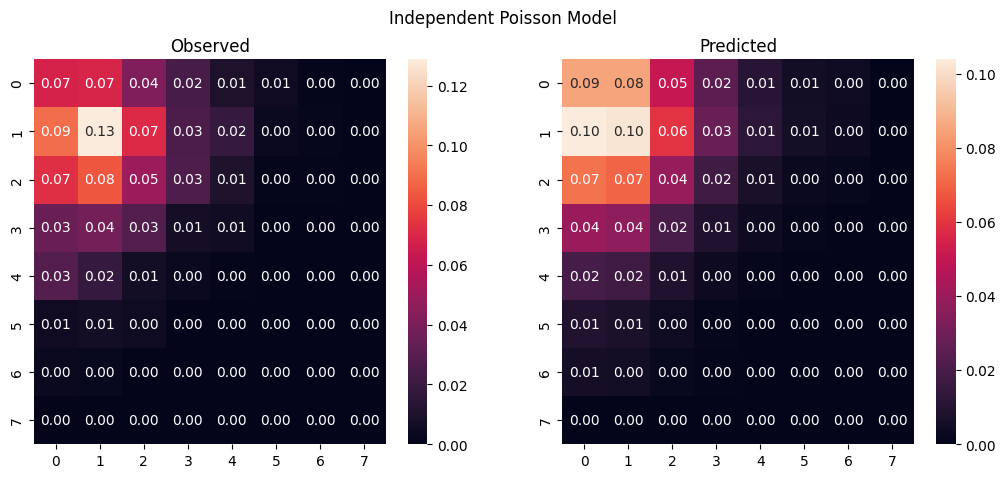

In [18]:
# actual
max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
res_table_a = np.array([np.zeros(max_goals) for _ in range(max_goals)])
for h, a in zip(actual_home, actual_away):
    res_table_a[int(h)][int(a)] += 1
res_table_a = res_table_a / test_data_orig_size

# predicted
max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
res_table_p = np.array([np.zeros(max_goals) for _ in range(max_goals)])

game_quotes = []
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    away_hist, bin_edges = np.histogram(
        predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    if home_hist.shape[0] < max_goals:
        home_hist = np.append(home_hist, np.zeros(max_goals - home_hist.shape[0]))
    if away_hist.shape[0] < max_goals:
        away_hist = np.append(away_hist, np.zeros(max_goals - away_hist.shape[0]))

    home_hist = home_hist / 1000
    away_hist = away_hist / 1000
    probs = home_hist.reshape(home_hist.shape[0], 1) * away_hist
    probs = probs
    res_table_p += probs

res_table_p = res_table_p / test_data_orig_size

# sb.heatmap(res_table_p, annot=True)

# top pred result:
max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
res_table_pr = np.array([np.zeros(max_goals) for _ in range(max_goals)])

game_quotes = []
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    away_hist, bin_edges = np.histogram(
        predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    res_table_pr[np.argmax(home_hist)][np.argmax(away_hist)] += 1
res_table_pr = res_table_pr / test_data_orig_size
# sb.heatmap(res_table_pr, annot=True)

fig, axes = plt.subplots(1, 2, figsize=(12.5, 5))
fig.suptitle("Independent Poisson Model")
sb.heatmap(ax=axes[0], data=res_table_a, annot=True, fmt=".2f")
axes[0].set_title("Observed")
sb.heatmap(ax=axes[1], data=res_table_p, annot=True, fmt=".2f")
axes[1].set_title("Predicted")

In [19]:
print(np.tril(res_table_a).sum() - np.trace(res_table_a))
print(np.trace(res_table_a))
print(np.triu(res_table_a).sum() - np.trace(res_table_a))

0.4278317152103559
0.25501618122977343
0.31715210355987045


In [20]:
print(np.tril(res_table_p).sum() - np.trace(res_table_p))
print(np.trace(res_table_p))
print(np.triu(res_table_p).sum() - np.trace(res_table_p))

0.43109253203883496
0.23672388737864086
0.32536683559870544


In [21]:
# max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
# res_table = np.array([np.zeros(max_goals) for _ in range(max_goals)])

# game_quotes = []
# for game_idx in range(len(predictions_home)):
#     home_hist, bin_edges = np.histogram(predictions_home[game_idx], [0,1,2,3,4,5,6,7])
#     away_hist, bin_edges = np.histogram(predictions_away[game_idx], [0,1,2,3,4,5,6,7])
#     if home_hist.shape[0] < max_goals:
#         home_hist = np.append(home_hist, np.zeros(max_goals - home_hist.shape[0]))
#     if away_hist.shape[0] < max_goals:
#         away_hist = np.append(away_hist, np.zeros(max_goals - away_hist.shape[0]))

#     home_hist = home_hist / 1000
#     away_hist = away_hist / 1000
#     probs = home_hist.reshape(home_hist.shape[0], 1) * away_hist
#     probs = probs
#     res_table += probs


# for x in range(len(res_table)):
#     for y in range(len(res_table[x])):
#         if x == y:
#             res_table[x][y] *= 1.2
#         else:
#             res_table[x][y] *= 0.95

# res_table = res_table / test_data_orig_size
# print(sum(sum(res_table)))
# sb.heatmap(res_table, annot=True)

In [22]:
df_cross

,actual,pred,pred_val,bookie,bookie_val
0,1,0,0.606,2,37.290950
1,0,0,0.414,0,62.975779
2,0,0,0.693,2,50.000000
3,0,0,0.756,0,81.810744
4,2,0,0.367,0,52.927174
...,...,...,...,...,...
1540,2,2,0.766,2,62.263129
1541,0,0,0.603,0,83.160083
1542,2,2,0.452,2,65.430464
1543,1,0,0.408,2,54.500255


In [23]:
# ece
data_length = df_cross.shape[0]

# acc_model = np.sum(df_cross['actual'] == df_cross['pred']) / data_length
# acc_bookie = np.sum(df_cross['bookie'] == df_cross['actual']) / data_length

# print("Accuracy Model: ", acc_model)
# print("Accuracy Bookie: ", acc_bookie)

# conf_model = np.sum(df_cross['pred_val']) / data_length
# conf_bookie = np.sum(df_cross['bookie_val']/100) / data_length

# print("Confidence Model: ", conf_model)
# print("Confidence Bookie: ", conf_bookie)

# ece_model = np.mean(np.absolute(acc_model - conf_model))
# ece_bookie = np.mean(np.absolute(acc_bookie - conf_bookie))

# print(f"Model ECE: {ece_model}")
# print(f"Bookie ECE: {ece_bookie}")
acc_home = (
    df_cross.loc[(df_cross["bookie"] == 0) & (df_cross["actual"] == 0)].shape[0]
) / df_cross.loc[df_cross["actual"] == 0].shape[0]
acc_draw = (
    df_cross.loc[(df_cross["bookie"] == 1) & (df_cross["actual"] == 1)].shape[0]
) / df_cross.loc[df_cross["actual"] == 1].shape[0]
acc_away = (
    df_cross.loc[(df_cross["bookie"] == 2) & (df_cross["actual"] == 2)].shape[0]
) / df_cross.loc[df_cross["actual"] == 2].shape[0]

conf_home = np.mean(df_cross.loc[(df_cross["bookie"] == 0)].bookie_val / 100)
conf_draw = np.mean(df_cross.loc[(df_cross["bookie"] == 1)].bookie_val / 100)
conf_away = np.mean(df_cross.loc[(df_cross["bookie"] == 2)].bookie_val / 100)
print(acc_home - conf_home)
print(acc_draw - conf_draw)
print(acc_away - conf_away)


acc_home = (
    df_cross.loc[(df_cross["pred"] == 0) & (df_cross["actual"] == 0)].shape[0]
) / df_cross.loc[df_cross["actual"] == 0].shape[0]
acc_draw = (
    df_cross.loc[(df_cross["pred"] == 1) & (df_cross["actual"] == 1)].shape[0]
) / df_cross.loc[df_cross["actual"] == 1].shape[0]
acc_away = (
    df_cross.loc[(df_cross["pred"] == 2) & (df_cross["actual"] == 2)].shape[0]
) / df_cross.loc[df_cross["actual"] == 2].shape[0]

conf_home = np.mean(df_cross.loc[(df_cross["pred"] == 0)].pred_val)
conf_draw = np.mean(df_cross.loc[(df_cross["pred"] == 1)].pred_val)
conf_away = np.mean(df_cross.loc[(df_cross["pred"] == 2)].pred_val)
print(acc_home - conf_home)
print(acc_draw - conf_draw)
print(acc_away - conf_away)

0.2601783491155203
nan
0.06721056586652263
0.2813844070319642
-0.3404290548706793
0.1177814386317908


In [24]:
bet_threshold = 10
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) - bookie_h > bet_threshold:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) - bookie_d > bet_threshold:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) - bookie_a > bet_threshold:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 1004
# won: 467
# lost: 537
# money:  6749.102471962487

bets: 835
won: 421
lost: 414
money:  4898.799999999999


In [25]:
bet_threshold = 60
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) >= bet_threshold:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) >= bet_threshold:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) >= bet_threshold:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 381
# won: 319
# lost: 62
# money:  2066.035947551149

bets: 484
won: 387
lost: 97
money:  2429.6000000000017


In [26]:
bet_threshold = 10
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) - bookie_h > bet_threshold or (float(pred_h) * 100) >= 60:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) - bookie_d > bet_threshold or (float(pred_d) * 100) >= 60:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) - bookie_a > bet_threshold or (float(pred_a) * 100) >= 60:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 1206
# won: 640
# lost: 566
# money:  7222.5381890291965

bets: 1040
won: 590
lost: 450
money:  5175.300000000002


# Inflated Diagonal

In [27]:
print(np.trace(res_table_a) / np.trace(res_table_p))
print(np.trace(res_table_a) / (np.trace(res_table_p) * (np.trace(res_table_a) / np.trace(res_table_p))))


print((np.tril(res_table_a).sum() - np.trace(res_table_a) + np.triu(res_table_a).sum() - np.trace(res_table_a)) / 
      ((np.tril(res_table_p).sum() - np.trace(res_table_p) + np.triu(res_table_p).sum() - np.trace(res_table_p)) * 
       (np.tril(res_table_a).sum() - np.trace(res_table_a) + np.triu(res_table_a).sum() - np.trace(res_table_a)) / 
      ((np.tril(res_table_p).sum() - np.trace(res_table_p) + np.triu(res_table_p).sum() - np.trace(res_table_p)))))

1.0772726996573605
1.0
1.0


In [28]:
mult_diagonal = (np.trace(res_table_a) / np.trace(res_table_p))
mult_rest =  (np.tril(res_table_a).sum() - np.trace(res_table_a) + np.triu(res_table_a).sum() - np.trace(res_table_a)) / ((np.tril(res_table_p).sum() - np.trace(res_table_p) + np.triu(res_table_p).sum() - np.trace(res_table_p)))

In [29]:
home_std = np.std(predictions_home, axis=1)
away_std = np.std(predictions_away, axis=1)
print(f"Home std: {home_std.mean()}, Away std: {away_std.mean()}, Overall std: {(home_std.mean() + away_std.mean()) / 2}")

Home std: 1.2029605404507087, Away std: 1.0882432544424294, Overall std: 1.1456018974465692


In [30]:
all_probs = []
game_quotes = []
most_goals = {"home": [], "away": []}
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    away_hist, bin_edges = np.histogram(
        predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    if home_hist.shape[0] < max_goals:
        home_hist = np.append(home_hist, np.zeros(max_goals - home_hist.shape[0]))
    if away_hist.shape[0] < max_goals:
        away_hist = np.append(away_hist, np.zeros(max_goals - away_hist.shape[0]))
    home_hist = home_hist / 1000
    away_hist = away_hist / 1000
    probs = home_hist.reshape(home_hist.shape[0], 1) * away_hist
    for x in range(len(probs)):
        for y in range(len(probs[x])):
            if x == y:
                probs[x][y] *= 1.3
            else:
                probs[x][y] *= 1 - 0.085
            # if x == y:
            #     probs[x][y] *= mult_diagonal
            # else:
            #     probs[x][y] *= mult_rest
    all_probs.append(np.array(probs))
    home = np.tril(probs).sum() - np.trace(probs)
    draw = np.trace(probs)
    away = np.triu(probs).sum() - np.trace(probs)
    game_quotes.append(f"{home}-{draw}-{away}")
    most_goals["home"].append(
        f"h: {np.argmax(home_hist)} - {round(np.max(home_hist)/10)}%"
    )
    most_goals["away"].append(
        f"a: {np.argmax(away_hist)} - {round(np.max(away_hist)/10)}%"
    )

df_res = pd.DataFrame(
    {
        "actual": act_res,
        "predicted": game_quotes,
        "prob goals home": most_goals["home"],
        "prob goals away": most_goals["away"],
    }
)
df_cross = pd.DataFrame(
    {
        "actual": [
            0
            if int(df_res.iloc[x]["actual"].split(":")[0])
            > int(df_res.iloc[x]["actual"].split(":")[1])
            else 1
            if int(df_res.iloc[x]["actual"].split(":")[0])
            == int(df_res.iloc[x]["actual"].split(":")[1])
            else 2
            for x in range(df_res.shape[0])
        ],
        "pred": [
            np.argmax([float(y) for y in df_res.iloc[x]["predicted"].split("-")])
            for x in range(df_res.shape[0])
        ],
        "pred_val": [
            np.max([float(y) for y in df_res.iloc[x]["predicted"].split("-")])
            for x in range(df_res.shape[0])
        ],
        "bookie": [
            np.argmax(
                [
                    test_data.iloc[x].bookie_home,
                    test_data.iloc[x].bookie_draw,
                    test_data.iloc[x].bookie_away,
                ]
            )
            for x in range(test_data_orig_size)
        ],
        "bookie_val": [
            np.max(
                [
                    test_data.iloc[x].bookie_home,
                    test_data.iloc[x].bookie_draw,
                    test_data.iloc[x].bookie_away,
                ]
            )
            for x in range(test_data_orig_size)
        ],
    }
)

In [31]:
print("Verteilung:")
print(
    f"Anzahl Predicted Home: {df_cross[df_cross['pred'] == 0].shape[0]} ({round(df_cross[df_cross['pred'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Home: {round(df_cross[df_cross['actual'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    f"Anzahl Predicted Draw: {df_cross[df_cross['pred'] == 1].shape[0]} ({round(df_cross[df_cross['pred'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Draw: {round(df_cross[df_cross['actual'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    f"Anzahl Predicted Away: {df_cross[df_cross['pred'] == 2].shape[0]} ({round(df_cross[df_cross['pred'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Away: {round(df_cross[df_cross['actual'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    "---------------------------------------------------------------------------------"
)
right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
home_pred = {"act_away": 0, "act_draw": 0}
draw_pred = {"act_away": 0, "act_home": 0}
away_pred = {"act_home": 0, "act_draw": 0}
for x in range(df_cross.shape[0]):
    if df_cross.iloc[x]["actual"] != df_cross.iloc[x]["pred"]:
        if df_cross.iloc[x]["pred"] == 0:
            if df_cross.iloc[x]["actual"] == 1:
                home_pred["act_draw"] += 1
            else:
                home_pred["act_away"] += 1
        elif df_cross.iloc[x]["pred"] == 1:
            if df_cross.iloc[x]["actual"] == 0:
                draw_pred["act_home"] += 1
            else:
                draw_pred["act_away"] += 1
        else:
            if df_cross.iloc[x]["actual"] == 0:
                away_pred["act_home"] += 1
            else:
                away_pred["act_draw"] += 1
        wrong += 1
    else:
        if df_cross.iloc[x]["actual"] == 0:
            home_right += 1
        elif df_cross.iloc[x]["actual"] == 1:
            draw_right += 1
        else:
            away_right += 1
        right += 1

home_wrong = home_pred["act_away"] + home_pred["act_draw"]
draw_wrong = draw_pred["act_away"] + draw_pred["act_home"]
away_wrong = away_pred["act_home"] + away_pred["act_draw"]
print("Prediction:")
print(
    f"Anzahl Korrekt: {right} ({round(right / df_cross.shape[0] * 100,2)}%), Anzahl Falsch: {wrong} ({round(wrong / df_cross.shape[0] * 100, 2)}%)"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    f"Anzahl Home Korrekt: {home_right} ({round(home_right / df_cross[df_cross['actual'] == 0].shape[0] * 100, 2)}%), Anzahl Home Falsch: {home_wrong}"
)
print(f"Home Pred. aber Draw --> {home_pred['act_draw']}")
print(f"Home Pred. aber Away --> {home_pred['act_away']}")
print(
    f"Anzahl Draw Korrekt: {draw_right} ({round(draw_right / df_cross[df_cross['actual'] == 1].shape[0] * 100, 2)}%), Anzahl Draw Falsch: {draw_wrong}"
)
print(f"Draw Pred. aber Home --> {draw_pred['act_home']}")
print(f"Draw Pred. aber Away --> {draw_pred['act_away']}")
print(
    f"Anzahl Away Korrekt: {away_right} ({round(away_right / df_cross[df_cross['actual'] == 2].shape[0] * 100, 2)}%), Anzahl Away Falsch: {away_wrong}"
)
print(f"Away Pred. aber Home --> {away_pred['act_home']}")
print(f"Away Pred. aber Draw --> {away_pred['act_draw']}")

Verteilung:
Anzahl Predicted Home: 788 (51.0%) | Verteilung Tatsächlich Home: 42.78%
Anzahl Predicted Draw: 295 (19.09%) | Verteilung Tatsächlich Draw: 25.5%
Anzahl Predicted Away: 462 (29.9%) | Verteilung Tatsächlich Away: 31.72%
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Prediction:
Anzahl Korrekt: 878 (56.83%), Anzahl Falsch: 667 (43.17%)
---------------------------------------------------------------------------------
Anzahl Home Korrekt: 488 (73.83%), Anzahl Home Falsch: 300
Home Pred. aber Draw --> 169
Home Pred. aber Away --> 131
Anzahl Draw Korrekt: 113 (28.68%), Anzahl Draw Falsch: 182
Draw Pred. aber Home --> 100
Draw Pred. aber Away --> 82
Anzahl Away Korrekt: 277 (56.53%), Anzahl Away Falsch: 185
Away Pred. aber Home --> 73
Away Pred. aber Draw --> 112


In [78]:
h = np.array([np.array(xi, dtype=float) for xi in df_res.predicted.str.split("-")])[:,0]
d = np.array([np.array(xi, dtype=float) for xi in df_res.predicted.str.split("-")])[:,1]
a = np.array([np.array(xi, dtype=float) for xi in df_res.predicted.str.split("-")])[:,2]

print(np.mean(h))
print(np.mean(d))
print(np.mean(a))

0.394449666815534
0.307741053592233
0.29771065457281554


In [32]:
home_histograms, away_histograms = [], []
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6]
    )
    away_hist, bin_edges = np.histogram(
        predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6]
    )
    home_histograms.append(home_hist)
    away_histograms.append(away_hist)

home_cum_hist = np.sum(home_histograms, axis=0)
away_cum_hist = np.sum(away_histograms, axis=0)

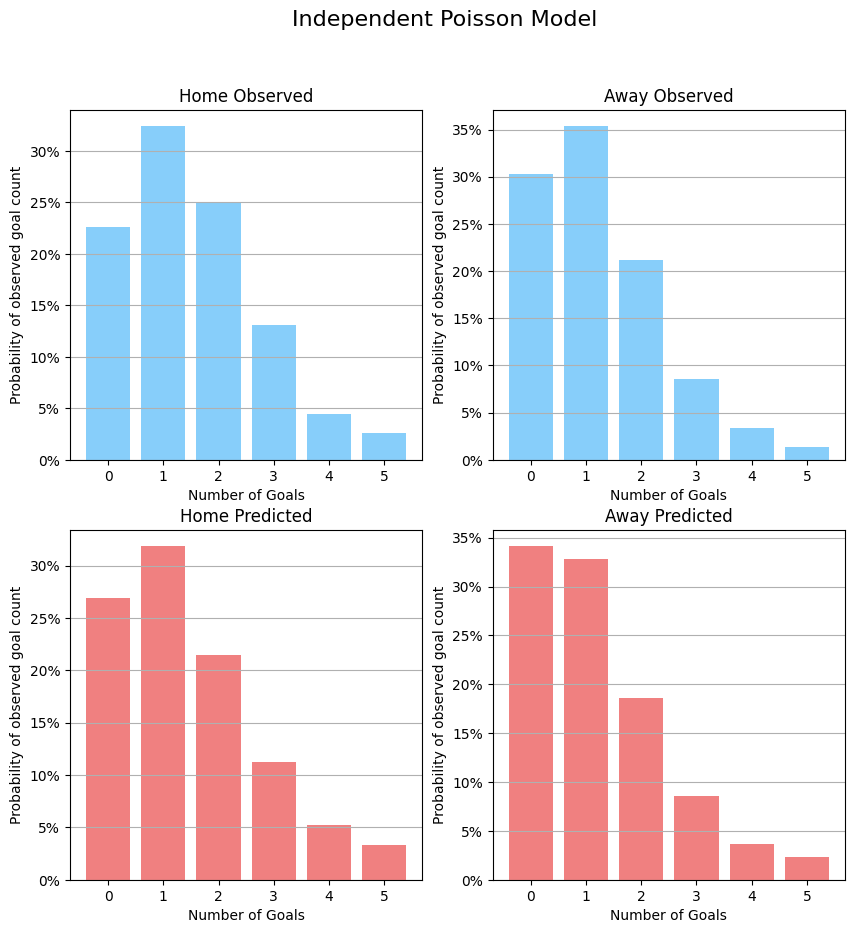

In [33]:
his_h, _ = np.histogram(train_data.home_score, [0, 1, 2, 3, 4, 5, 6])
his_a, _ = np.histogram(train_data.away_score, [0, 1, 2, 3, 4, 5, 6])
fig, (ax1, ax2) = plt.subplots(2, 2)
fig.set_size_inches(10, 10)
fig.suptitle("Independent Poisson Model", fontsize=16)
ax1[0].bar(np.arange(len(his_h)), his_h / np.sum(his_h), color="lightskyblue")
ax1[0].set_title("Home Observed")
ax1[0].set_xlabel("Number of Goals")
ax1[0].set_ylabel("Probability of observed goal count")
ax1[0].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax1[0].grid(axis="y")

ax2[0].bar(
    np.arange(len(home_cum_hist)),
    home_cum_hist / np.sum(home_cum_hist),
    color="lightcoral",
)
ax2[0].set_title("Home Predicted")
ax2[0].set_xlabel("Number of Goals")
ax2[0].set_ylabel("Probability of observed goal count")
ax2[0].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax2[0].grid(axis="y")

ax1[1].bar(np.arange(len(his_a)), his_a / np.sum(his_a), color="lightskyblue")
ax1[1].set_title("Away Observed")
ax1[1].set_xlabel("Number of Goals")
ax1[1].set_ylabel("Probability of observed goal count")
ax1[1].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax1[1].grid(axis="y")

ax2[1].bar(
    np.arange(len(away_cum_hist)),
    away_cum_hist / np.sum(away_cum_hist),
    color="lightcoral",
)
ax2[1].set_title("Away Predicted")
ax2[1].set_xlabel("Number of Goals")
ax2[1].set_ylabel("Probability of observed goal count")
ax2[1].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax2[1].grid(axis="y")

In [34]:
print(np.sum([x * idx for idx, x in enumerate(home_cum_hist)]) / np.sum(home_cum_hist))
print(np.sum([x * idx for idx, x in enumerate(away_cum_hist)]) / np.sum(away_cum_hist))

1.4582881595669062
1.2171925484932145


In [35]:
res_table_p = np.array([sum(x) for x in zip(*all_probs)])
res_table_p.shape
res_table_p = res_table_p / test_data_orig_size

Text(0.5, 25.722222222222214, 'Away Goals')

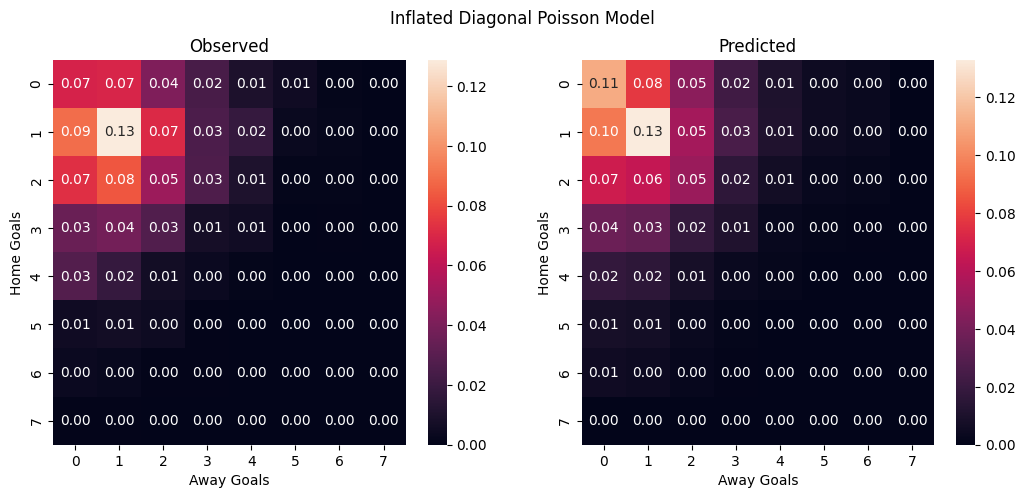

In [36]:
# actual
max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
res_table_a = np.array([np.zeros(max_goals) for _ in range(max_goals)])
for h, a in zip(actual_home, actual_away):
    res_table_a[int(h)][int(a)] += 1
res_table_a = res_table_a / test_data_orig_size

# predicted
# max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
# res_table_p = np.array([np.zeros(max_goals) for _ in range(max_goals)])

# game_quotes = []
# for game_idx in range(len(predictions_home)):
#     home_hist, bin_edges = np.histogram(predictions_home[game_idx], [0,1,2,3,4,5,6,7])
#     away_hist, bin_edges = np.histogram(predictions_away[game_idx], [0,1,2,3,4,5,6,7])
#     if home_hist.shape[0] < max_goals:
#         home_hist = np.append(home_hist, np.zeros(max_goals - home_hist.shape[0]))
#     if away_hist.shape[0] < max_goals:
#         away_hist = np.append(away_hist, np.zeros(max_goals - away_hist.shape[0]))

#     home_hist = home_hist / 1000
#     away_hist = away_hist / 1000
#     probs = home_hist.reshape(home_hist.shape[0], 1) * away_hist
#     probs = probs
#     res_table_p += probs

# res_table_p = res_table_p / test_data_orig_size


fig, axes = plt.subplots(1, 2, figsize=(12.5, 5))
fig.suptitle("Inflated Diagonal Poisson Model")
sb.heatmap(ax=axes[0], data=res_table_a, annot=True, fmt=".2f")
axes[0].set_title("Observed")
axes[0].set_ylabel("Home Goals")
axes[0].set_xlabel("Away Goals")
sb.heatmap(ax=axes[1], data=res_table_p, annot=True, fmt=".2f")
axes[1].set_title("Predicted")
axes[1].set_ylabel("Home Goals")
axes[1].set_xlabel("Away Goals")

In [37]:
print(np.tril(res_table_p).sum() - np.trace(res_table_p))
print(np.trace(res_table_p))
print(np.triu(res_table_p).sum() - np.trace(res_table_p))

print(
    np.sum(
        [
            np.tril(res_table_p).sum() - np.trace(res_table_p),
            np.trace(res_table_p),
            np.triu(res_table_p).sum() - np.trace(res_table_p),
        ]
    )
)

0.39444966681553423
0.30774105359223297
0.2977106545728156
0.9999013749805827


In [38]:
# ece
data_length = df_cross.shape[0]

# acc_model = np.sum(df_cross['actual'] == df_cross['pred']) / data_length
# acc_bookie = np.sum(df_cross['bookie'] == df_cross['actual']) / data_length

# print("Accuracy Model: ", acc_model)
# print("Accuracy Bookie: ", acc_bookie)

# conf_model = np.sum(df_cross['pred_val']) / data_length
# conf_bookie = np.sum(df_cross['bookie_val']/100) / data_length

# print("Confidence Model: ", conf_model)
# print("Confidence Bookie: ", conf_bookie)

# ece_model = np.mean(np.absolute(acc_model - conf_model))
# ece_bookie = np.mean(np.absolute(acc_bookie - conf_bookie))

# print(f"Model ECE: {ece_model}")
# print(f"Bookie ECE: {ece_bookie}")
acc_home = (
    df_cross.loc[(df_cross["bookie"] == 0) & (df_cross["actual"] == 0)].shape[0]
) / df_cross.loc[df_cross["actual"] == 0].shape[0]
acc_draw = (
    df_cross.loc[(df_cross["bookie"] == 1) & (df_cross["actual"] == 1)].shape[0]
) / df_cross.loc[df_cross["actual"] == 1].shape[0]
acc_away = (
    df_cross.loc[(df_cross["bookie"] == 2) & (df_cross["actual"] == 2)].shape[0]
) / df_cross.loc[df_cross["actual"] == 2].shape[0]

conf_home = np.mean(df_cross.loc[(df_cross["bookie"] == 0)].bookie_val / 100)
conf_draw = np.mean(df_cross.loc[(df_cross["bookie"] == 1)].bookie_val / 100)
conf_away = np.mean(df_cross.loc[(df_cross["bookie"] == 2)].bookie_val / 100)
print(acc_home - conf_home)
print(acc_draw - conf_draw)
print(acc_away - conf_away)


acc_home = (
    df_cross.loc[(df_cross["pred"] == 0) & (df_cross["actual"] == 0)].shape[0]
) / df_cross.loc[df_cross["actual"] == 0].shape[0]
acc_draw = (
    df_cross.loc[(df_cross["pred"] == 1) & (df_cross["actual"] == 1)].shape[0]
) / df_cross.loc[df_cross["actual"] == 1].shape[0]
acc_away = (
    df_cross.loc[(df_cross["pred"] == 2) & (df_cross["actual"] == 2)].shape[0]
) / df_cross.loc[df_cross["actual"] == 2].shape[0]

conf_home = np.mean(df_cross.loc[(df_cross["pred"] == 0)].pred_val)
conf_draw = np.mean(df_cross.loc[(df_cross["pred"] == 1)].pred_val)
conf_away = np.mean(df_cross.loc[(df_cross["pred"] == 2)].pred_val)
print(acc_home - conf_home)
print(acc_draw - conf_draw)
print(acc_away - conf_away)

0.2601783491155203
nan
0.06721056586652263
0.19887928722075454
-0.14012401564484211
0.04644898527365493


In [39]:
bet_threshold = 10
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) - bookie_h > bet_threshold:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) - bookie_d > bet_threshold:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) - bookie_a > bet_threshold:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 1004
# won: 467
# lost: 537
# money:  6749.102471962487

bets: 1042
won: 463
lost: 579
money:  5458.9


In [40]:
bet_threshold = 60
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) >= bet_threshold:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) >= bet_threshold:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) >= bet_threshold:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 381
# won: 319
# lost: 62
# money:  2066.035947551149

bets: 344
won: 286
lost: 58
money:  1647.0999999999997


In [41]:
bet_threshold = 10
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) - bookie_h > bet_threshold or (float(pred_h) * 100) >= 60:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) - bookie_d > bet_threshold or (float(pred_d) * 100) >= 60:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) - bookie_a > bet_threshold or (float(pred_a) * 100) >= 60:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 1206
# won: 640
# lost: 566
# money:  7222.5381890291965

bets: 1209
won: 607
lost: 602
money:  5737.9000000000015


In [42]:
df_cross

,actual,pred,pred_val,bookie,bookie_val
0,1,0,0.555470,2,37.290950
1,0,1,0.396273,0,62.975779
2,0,0,0.636088,2,50.000000
3,0,0,0.703972,0,81.810744
4,2,1,0.364651,0,52.927174
...,...,...,...,...,...
1540,2,2,0.725994,2,62.263129
1541,0,0,0.552514,0,83.160083
1542,2,2,0.413399,2,65.430464
1543,1,1,0.383864,2,54.500255
